In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import redpandda
from redpandda import *

import resicon
from resicon import *

import geostas
import mdtraj

import MDAnalysis as mda 

import visualizations
import comodo

import hdbscan


In [2]:
from redpandda import preprocessing, preprocess_protein_trajectory
import redpandda_general
from clustering_functions import clustering_workflow

In [3]:
#md_trajectory_info = ['trajectory-1.xtc','fs-peptide.pdb','McGibbon/',10000,4,'mcgib_traj1_geostas_4k.csv','Ace']
md_trajectory_info = ['trajectory-1.xtc','fs-peptide.pdb','McGibbon/',None,None,'mcgib_traj1_geostas_4k.csv','Ace']

#how many frames to process
frames_count = md_trajectory_info[3]

In [4]:
# call MD-related preprocessing
traj_array, k_cluster = preprocess_protein_trajectory(md_trajectory_info)

In [5]:
clustering_names = []
clustering_results = []

In [6]:
matrices_to_apply = ["delta", "delta w/o abs", "delta+1std", "delta+2std", "stddv"]
clusterings_to_apply = [
    {
        "name": "Spectral",
        "method": "spectral",
        "params": {"cluster_count": k_cluster, "sph": "dada"}
    },
        {
        "name": "HDBSCAN",
        "method": "hdbscan",
        "params": {}
    },
        {
        "name": "Affinity",
        "method": "affinity",
        "params": {}
    }
]


In [7]:
clusterings_to_apply

[{'name': 'Spectral',
  'method': 'spectral',
  'params': {'cluster_count': 4, 'sph': 'dada'}},
 {'name': 'HDBSCAN', 'method': 'hdbscan', 'params': {}},
 {'name': 'Affinity', 'method': 'affinity', 'params': {}}]

In [8]:
res = clustering_workflow(traj_array, matrices_to_apply, clusterings_to_apply)

0.0184
0.0023
0.0029
0.0069
0.0010
0.0015
0.0026
0.0013
0.0016
0.0040
0.0013
0.0034
0.0021
0.0012
0.0020


In [9]:
res

[{'name': 'Spectral',
  'method': 'spectral',
  'params': {'cluster_count': 4, 'sph': 'dada'},
  'matrix': 'delta',
  'clustering': array([0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1])},
 {'name': 'HDBSCAN',
  'method': 'hdbscan',
  'params': {},
  'matrix': 'delta',
  'clustering': array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4])},
 {'name': 'Affinity',
  'method': 'affinity',
  'params': {},
  'matrix': 'delta',
  'clustering': array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6])},
 {'name': 'Spectral',
  'method': 'spectral',
  'params': {'cluster_count': 4, 'sph': 'dada'},
  'matrix': 'delta w/o abs',
  'clustering': array([2, 0, 0, 2, 3, 3, 3, 0, 2, 3, 0, 2, 0, 0, 1, 1, 1, 0, 2, 1, 3])},
 {'name': 'HDBSCAN',
  'method': 'hdbscan',
  'params': {},
  'matrix': 'delta w/o abs',
  'clustering': array([ 0,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1,  0,  1])},
 {'name': 'Affinity',
  'method'

In [10]:
# create matrices for plotting
dist_matrices = redpandda_general.get_distance_matrices(traj_array)
delta_matrices = redpandda_general.get_delta_matrices(dist_matrices)
delta_matrices_wo_absolute = redpandda_general.get_delta_matrices_wo_absolute(dist_matrices)


average_delta_matrix = redpandda_general.calculate_average_delta_matrix(delta_matrices)
average_delta_matrix_wo_absolute = redpandda_general.calculate_average_delta_matrix(delta_matrices_wo_absolute)

average_distance_matrix = redpandda_general.calculate_average_delta_matrix(dist_matrices)

std_distance_matrix = redpandda_general.get_std_matrices(dist_matrices)
std_delta_matrix = redpandda_general.get_std_matrices(delta_matrices)

stddv_matrices = redpandda_general.get_stddv(dist_matrices)


summed_delta_matrix_1std = average_delta_matrix + std_delta_matrix 
summed_delta_matrix_2std = average_delta_matrix + std_delta_matrix * 2

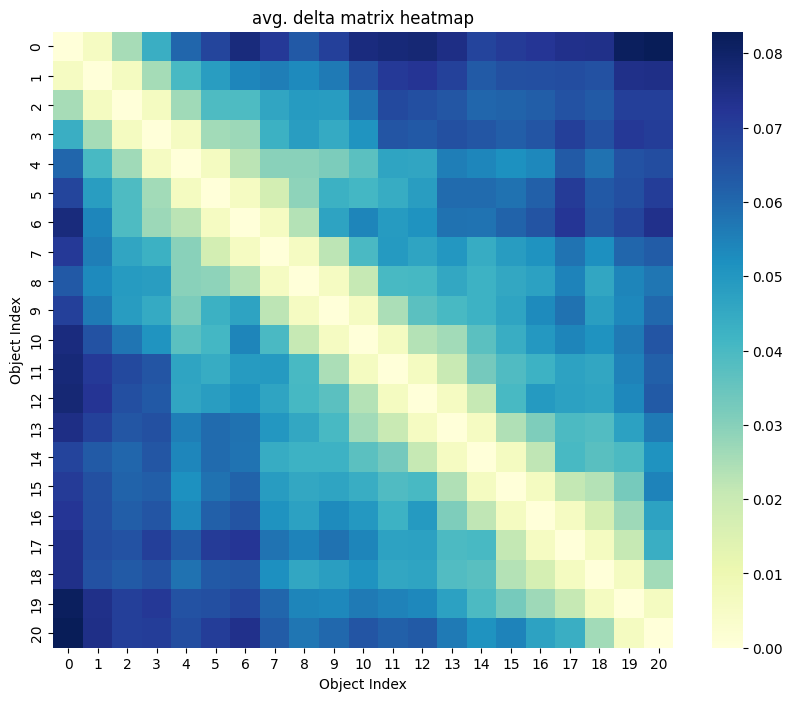

In [11]:
dm.create_delta_heatmap(average_delta_matrix)

In [12]:
res

[{'name': 'Spectral',
  'method': 'spectral',
  'params': {'cluster_count': 4, 'sph': 'dada'},
  'matrix': 'delta',
  'clustering': array([0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1])},
 {'name': 'HDBSCAN',
  'method': 'hdbscan',
  'params': {},
  'matrix': 'delta',
  'clustering': array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4])},
 {'name': 'Affinity',
  'method': 'affinity',
  'params': {},
  'matrix': 'delta',
  'clustering': array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6])},
 {'name': 'Spectral',
  'method': 'spectral',
  'params': {'cluster_count': 4, 'sph': 'dada'},
  'matrix': 'delta w/o abs',
  'clustering': array([2, 0, 0, 2, 3, 3, 3, 0, 2, 3, 0, 2, 0, 0, 1, 1, 1, 0, 2, 1, 3])},
 {'name': 'HDBSCAN',
  'method': 'hdbscan',
  'params': {},
  'matrix': 'delta w/o abs',
  'clustering': array([ 0,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1,  0,  1])},
 {'name': 'Affinity',
  'method'

In [22]:
for clustering in res:
    curr_clustering = clustering["clustering"]
    Q, _ = cc.get_Q_for_clustering(dist_matrices, curr_clustering, k_cluster)
    clustering["Q"] = Q

In [23]:
res

[{'name': 'Spectral',
  'method': 'spectral',
  'params': {'cluster_count': 4, 'sph': 'dada'},
  'matrix': 'delta',
  'clustering': array([0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]),
  'Q': 0.19216177},
 {'name': 'HDBSCAN',
  'method': 'hdbscan',
  'params': {},
  'matrix': 'delta',
  'clustering': array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4]),
  'Q': 0.06846477},
 {'name': 'Affinity',
  'method': 'affinity',
  'params': {},
  'matrix': 'delta',
  'clustering': array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6]),
  'Q': 0.040094655},
 {'name': 'Spectral',
  'method': 'spectral',
  'params': {'cluster_count': 4, 'sph': 'dada'},
  'matrix': 'delta w/o abs',
  'clustering': array([2, 0, 0, 2, 3, 3, 3, 0, 2, 3, 0, 2, 0, 0, 1, 1, 1, 0, 2, 1, 3]),
  'Q': 0.55653614},
 {'name': 'HDBSCAN',
  'method': 'hdbscan',
  'params': {},
  'matrix': 'delta w/o abs',
  'clustering': array([ 0,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

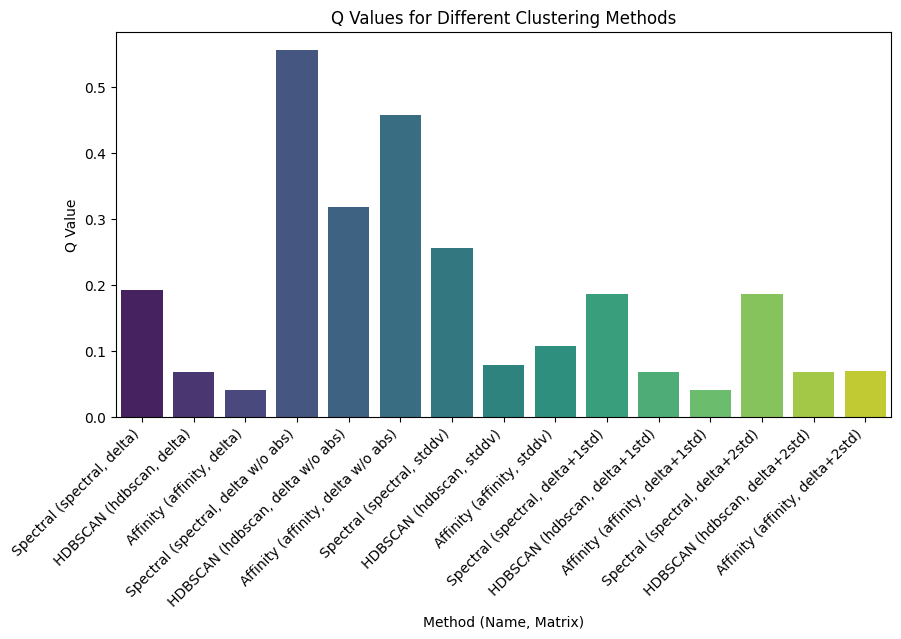


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



In [37]:
import seaborn as sns
labels = [f"{entry['name']} ({entry['method']}, {entry['matrix']})" for entry in res]
Q_values = [entry['Q'] for entry in res]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=labels, y=Q_values, palette="viridis")

# Labels and title
plt.xlabel("Method (Name, Matrix)")
plt.ylabel("Q Value")
plt.title("Q Values for Different Clustering Methods")
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()

In [41]:
clustering_hdbscan = res[1]["clustering"]
if -1 in clustering_hdbscan:
    from postprocess_clusterings import assign_noise_points
    final_clustering_hdbscan = assign_noise_points(distance_matrix=delta_matrices, cluster_labels=clustering_hdbscan)

[array([0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1])]
[0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
index
0


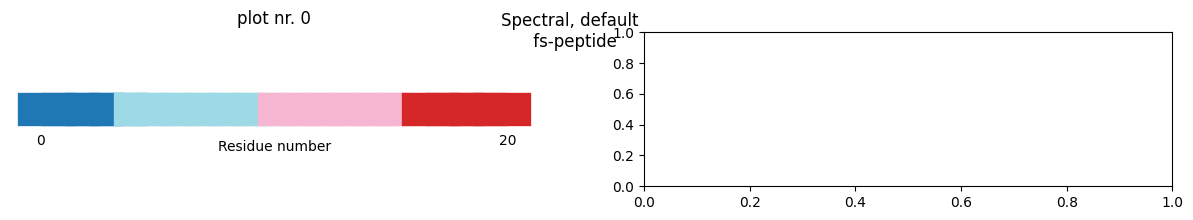

[array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4])]
[0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4]
index
0


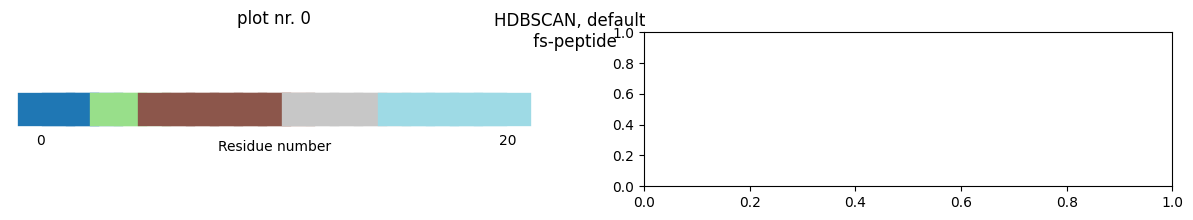

[array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6])]
[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6]
index
0


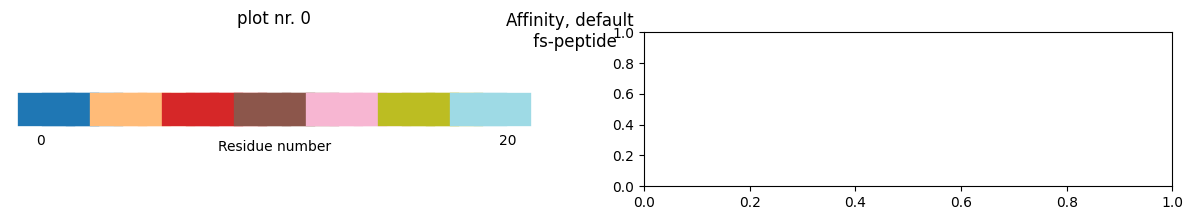

[array([2, 0, 0, 2, 3, 3, 3, 0, 2, 3, 0, 2, 0, 0, 1, 1, 1, 0, 2, 1, 3])]
[2, 0, 0, 2, 3, 3, 3, 0, 2, 3, 0, 2, 0, 0, 1, 1, 1, 0, 2, 1, 3]
index
0


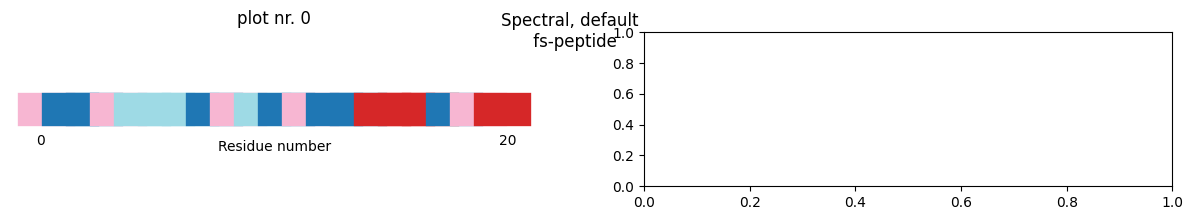

[array([ 0,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0,  1])]
[0, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 1]
index
0


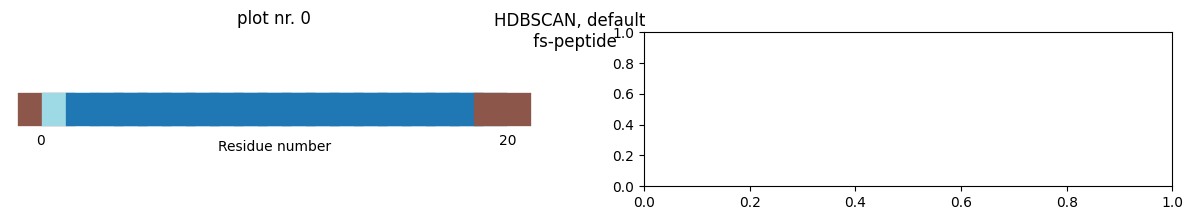

[array([0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])]
[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
index
0


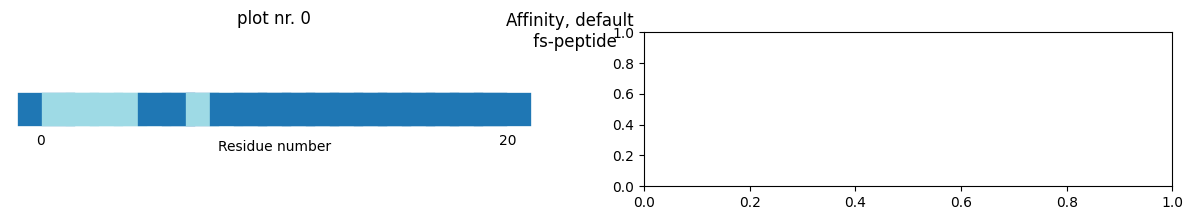

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 0, 0, 0, 0, 2, 2, 2])]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 0, 0, 0, 0, 2, 2, 2]
index
0


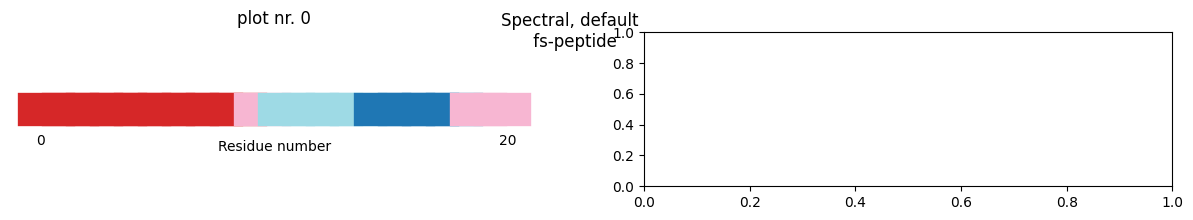

[array([ 0,  0,  0,  3,  3,  4,  4,  4,  4,  4,  4, -1,  2,  2,  2,  1,  1,
        1,  1,  1, -1])]
[0, 0, 0, 3, 3, 4, 4, 4, 4, 4, 4, -1, 2, 2, 2, 1, 1, 1, 1, 1, -1]
index
0


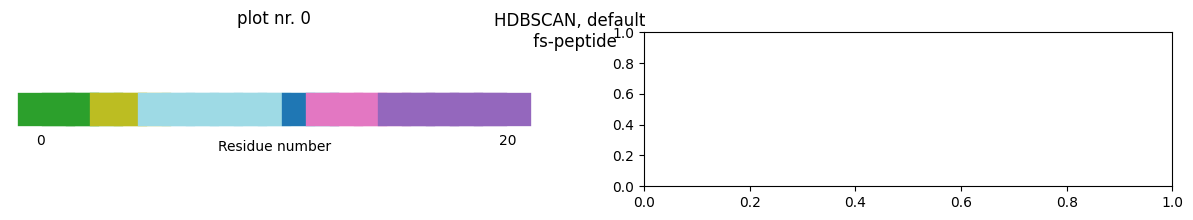

[array([0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4])]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4]
index
0


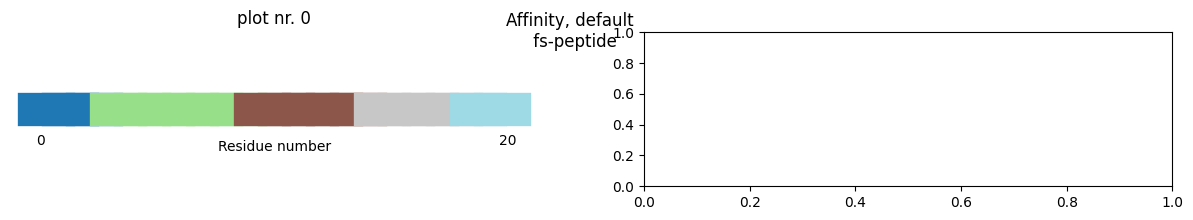

[array([2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])]
[2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
index
0


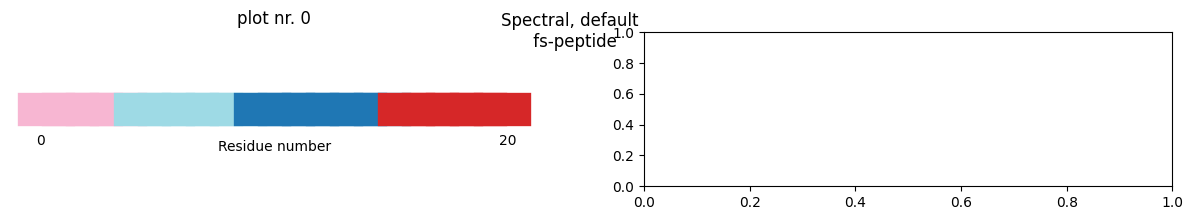

[array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4])]
[0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4]
index
0


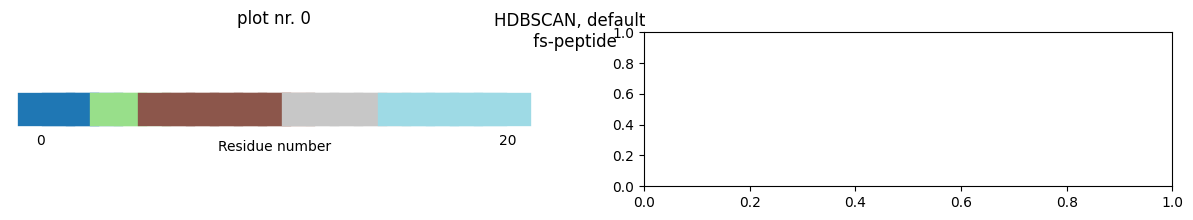

[array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6])]
[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6]
index
0


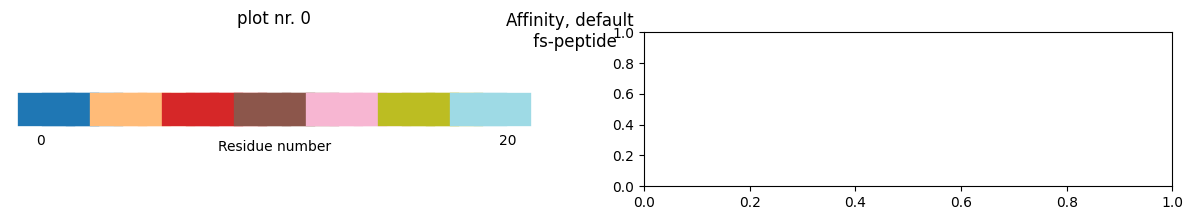

[array([2, 2, 2, 2, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1])]
[2, 2, 2, 2, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1]
index
0


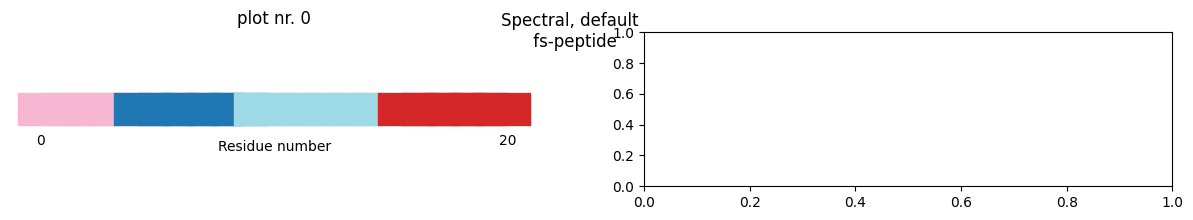

[array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4])]
[0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4]
index
0


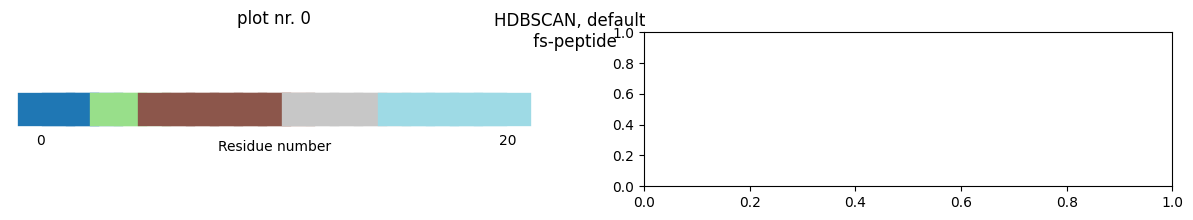

[array([0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5])]
[0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5]
index
0


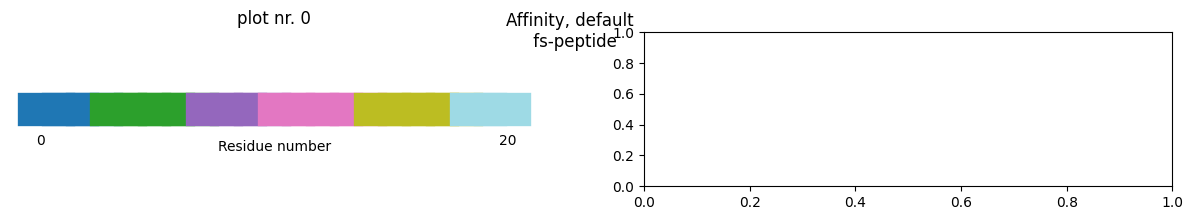

In [26]:
for clustering in res:
    visualizations.line_plot_workflow([clustering["clustering"]], titles = None, full_title = clustering["name"] + ", default \n fs-peptide", rearrange = True, hdb_scan_noise=True)

# Additional methods - Resicon

In [27]:
resi_clustering = resicon(md_trajectory_info[0],md_trajectory_info[1],md_trajectory_info[2],k_cluster, only_CA=True)

0.3183
Resicon residue:
ALA
0
Resicon residue:
ALA
1
Resicon residue:
ALA
2
Resicon residue:
ALA
3
Resicon residue:
ALA
4
Resicon residue:
ALA
5
Resicon residue:
ALA
6
Resicon residue:
ALA
7
Resicon residue:
ARG
8
Resicon residue:
ALA
9
Resicon residue:
ALA
10
Resicon residue:
ALA
11
Resicon residue:
ALA
12
Resicon residue:
ARG
13
Resicon residue:
ALA
14
Resicon residue:
ALA
15
Resicon residue:
ALA
16
Resicon residue:
ALA
17
Resicon residue:
ARG
18
Resicon residue:
ALA
19
Resicon residue:
ALA
20
208.5013


# Additional methods - Comodo

In [29]:
import visualizations
import comodo

In [31]:
md_trajectory_info[0]

'trajectory-1.xtc'

In [29]:
md_trajectory_info_dcd = md_trajectory_info.copy()

In [30]:
md_trajectory_info_dcd[0] = "trajectory-1.dcd"

In [31]:
md_trajectory_info_dcd[0]


'trajectory-1.dcd'

In [32]:
md_trajectory_info_dcd

['trajectory-1.dcd',
 'fs-peptide.pdb',
 'McGibbon/',
 None,
 None,
 'mcgib_traj1_geostas_4k.csv',
 'Ace']

In [34]:
#com_pd_eln = comodo.full_comodo_clustering(os.path.join("trajdata",md_trajectory_info_dcd[2], md_trajectory_info_dcd[0]), elastic_network=False)
com_pd_no_eln = comodo.full_comodo_clustering(os.path.join("trajdata",md_trajectory_info_dcd[0]), elastic_network=True)

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: Error in (function (file, maxlines = -1, multi = FALSE, rm.insert = FALSE,  : 
  No input PDB file found: check filename



RRuntimeError: Error in (function (file, maxlines = -1, multi = FALSE, rm.insert = FALSE,  : 
  No input PDB file found: check filename


# Additional methods - GeoStas

In [35]:
from geostas import *
geostas_clusters = compute_geostas_clusters_dcd(os.path.join("trajdata",md_trajectory_info_dcd[2], md_trajectory_info_dcd[0]))

 NATOM = 264 
 NFRAME= 10000 
 ISTART= 0 
 last  = 10000 
 nstep = 0 
 nfile = 0 
 NSAVE = 1 
 NDEGF = 0 
 version 24 
  |======================================================================| 100%
  .. 'xyz' coordinate data with 10000 frames 
  .. 'fit=TRUE': running function 'core.find'


R[write to console]: 

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



RRuntimeError: Error in (function (file, maxlines = -1, multi = FALSE, rm.insert = FALSE,  : 
  No input PDB file found: check filename


# Distribution visualization

In [76]:
from compare_distributions import dist_heatmaps_for_matrices

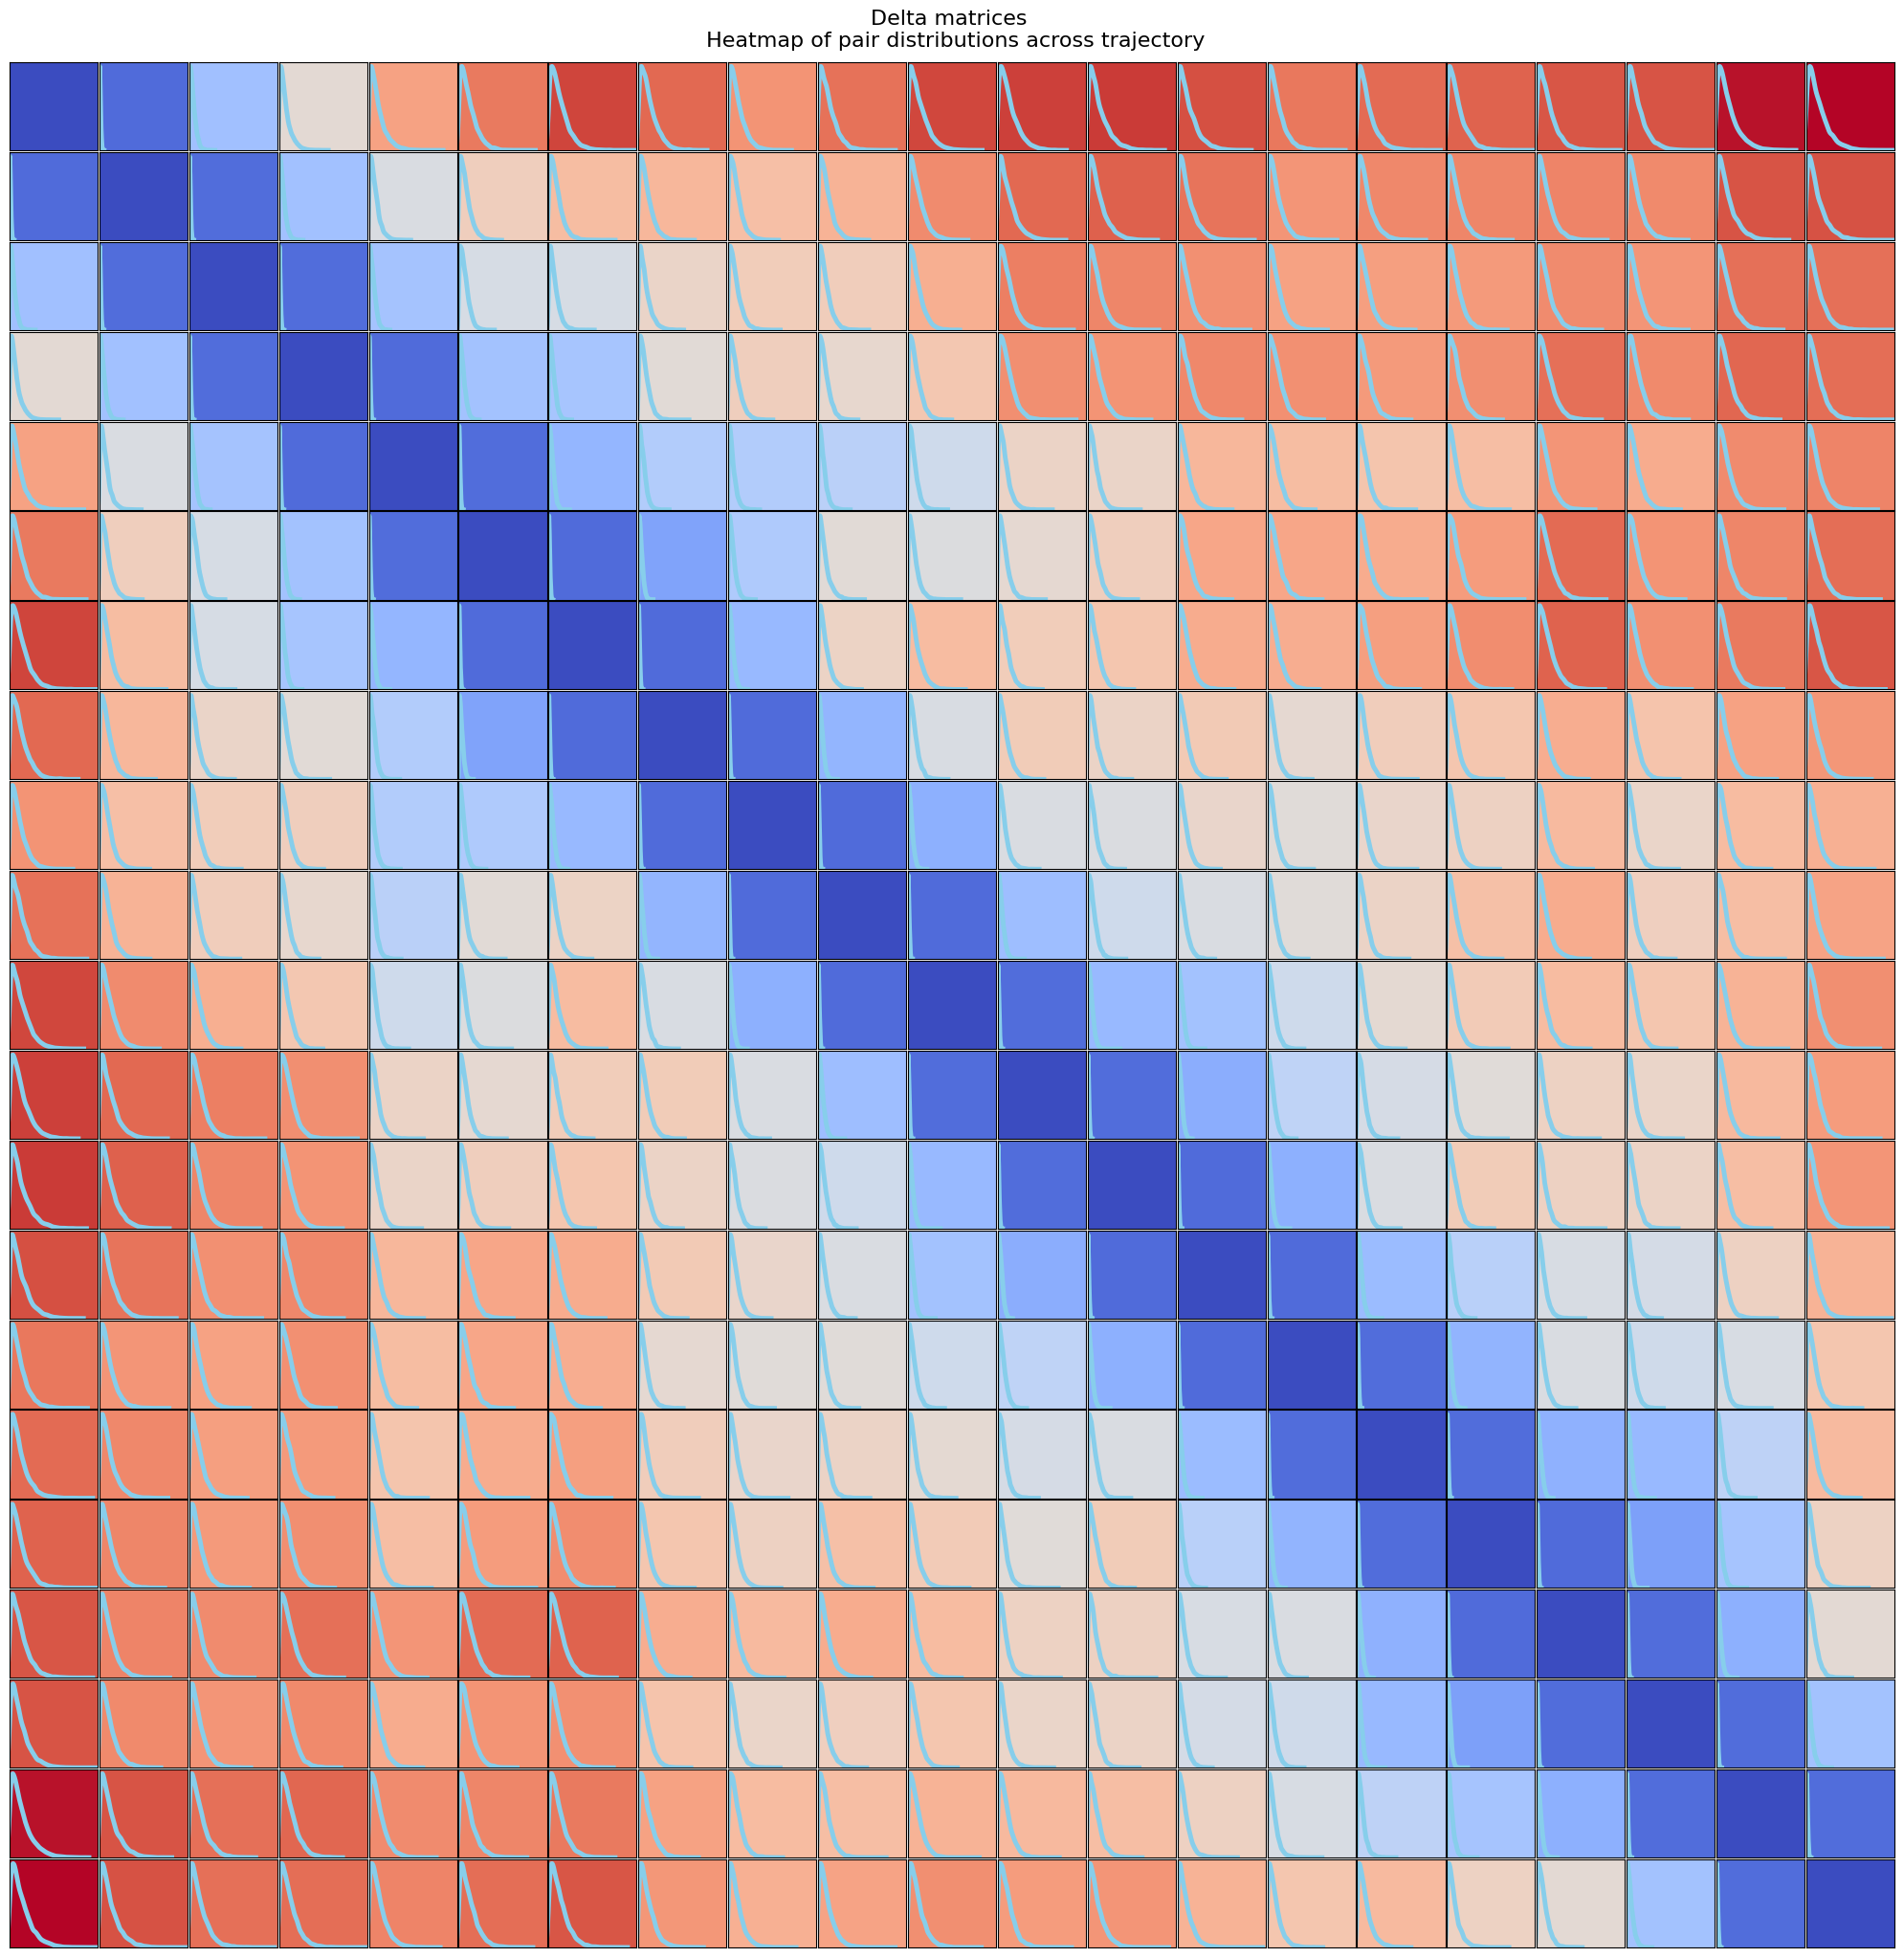

In [ ]:
dist_heatmaps_for_matrices(delta_matrices,title="Delta matrices \n Heatmap of pair distributions across trajectory")


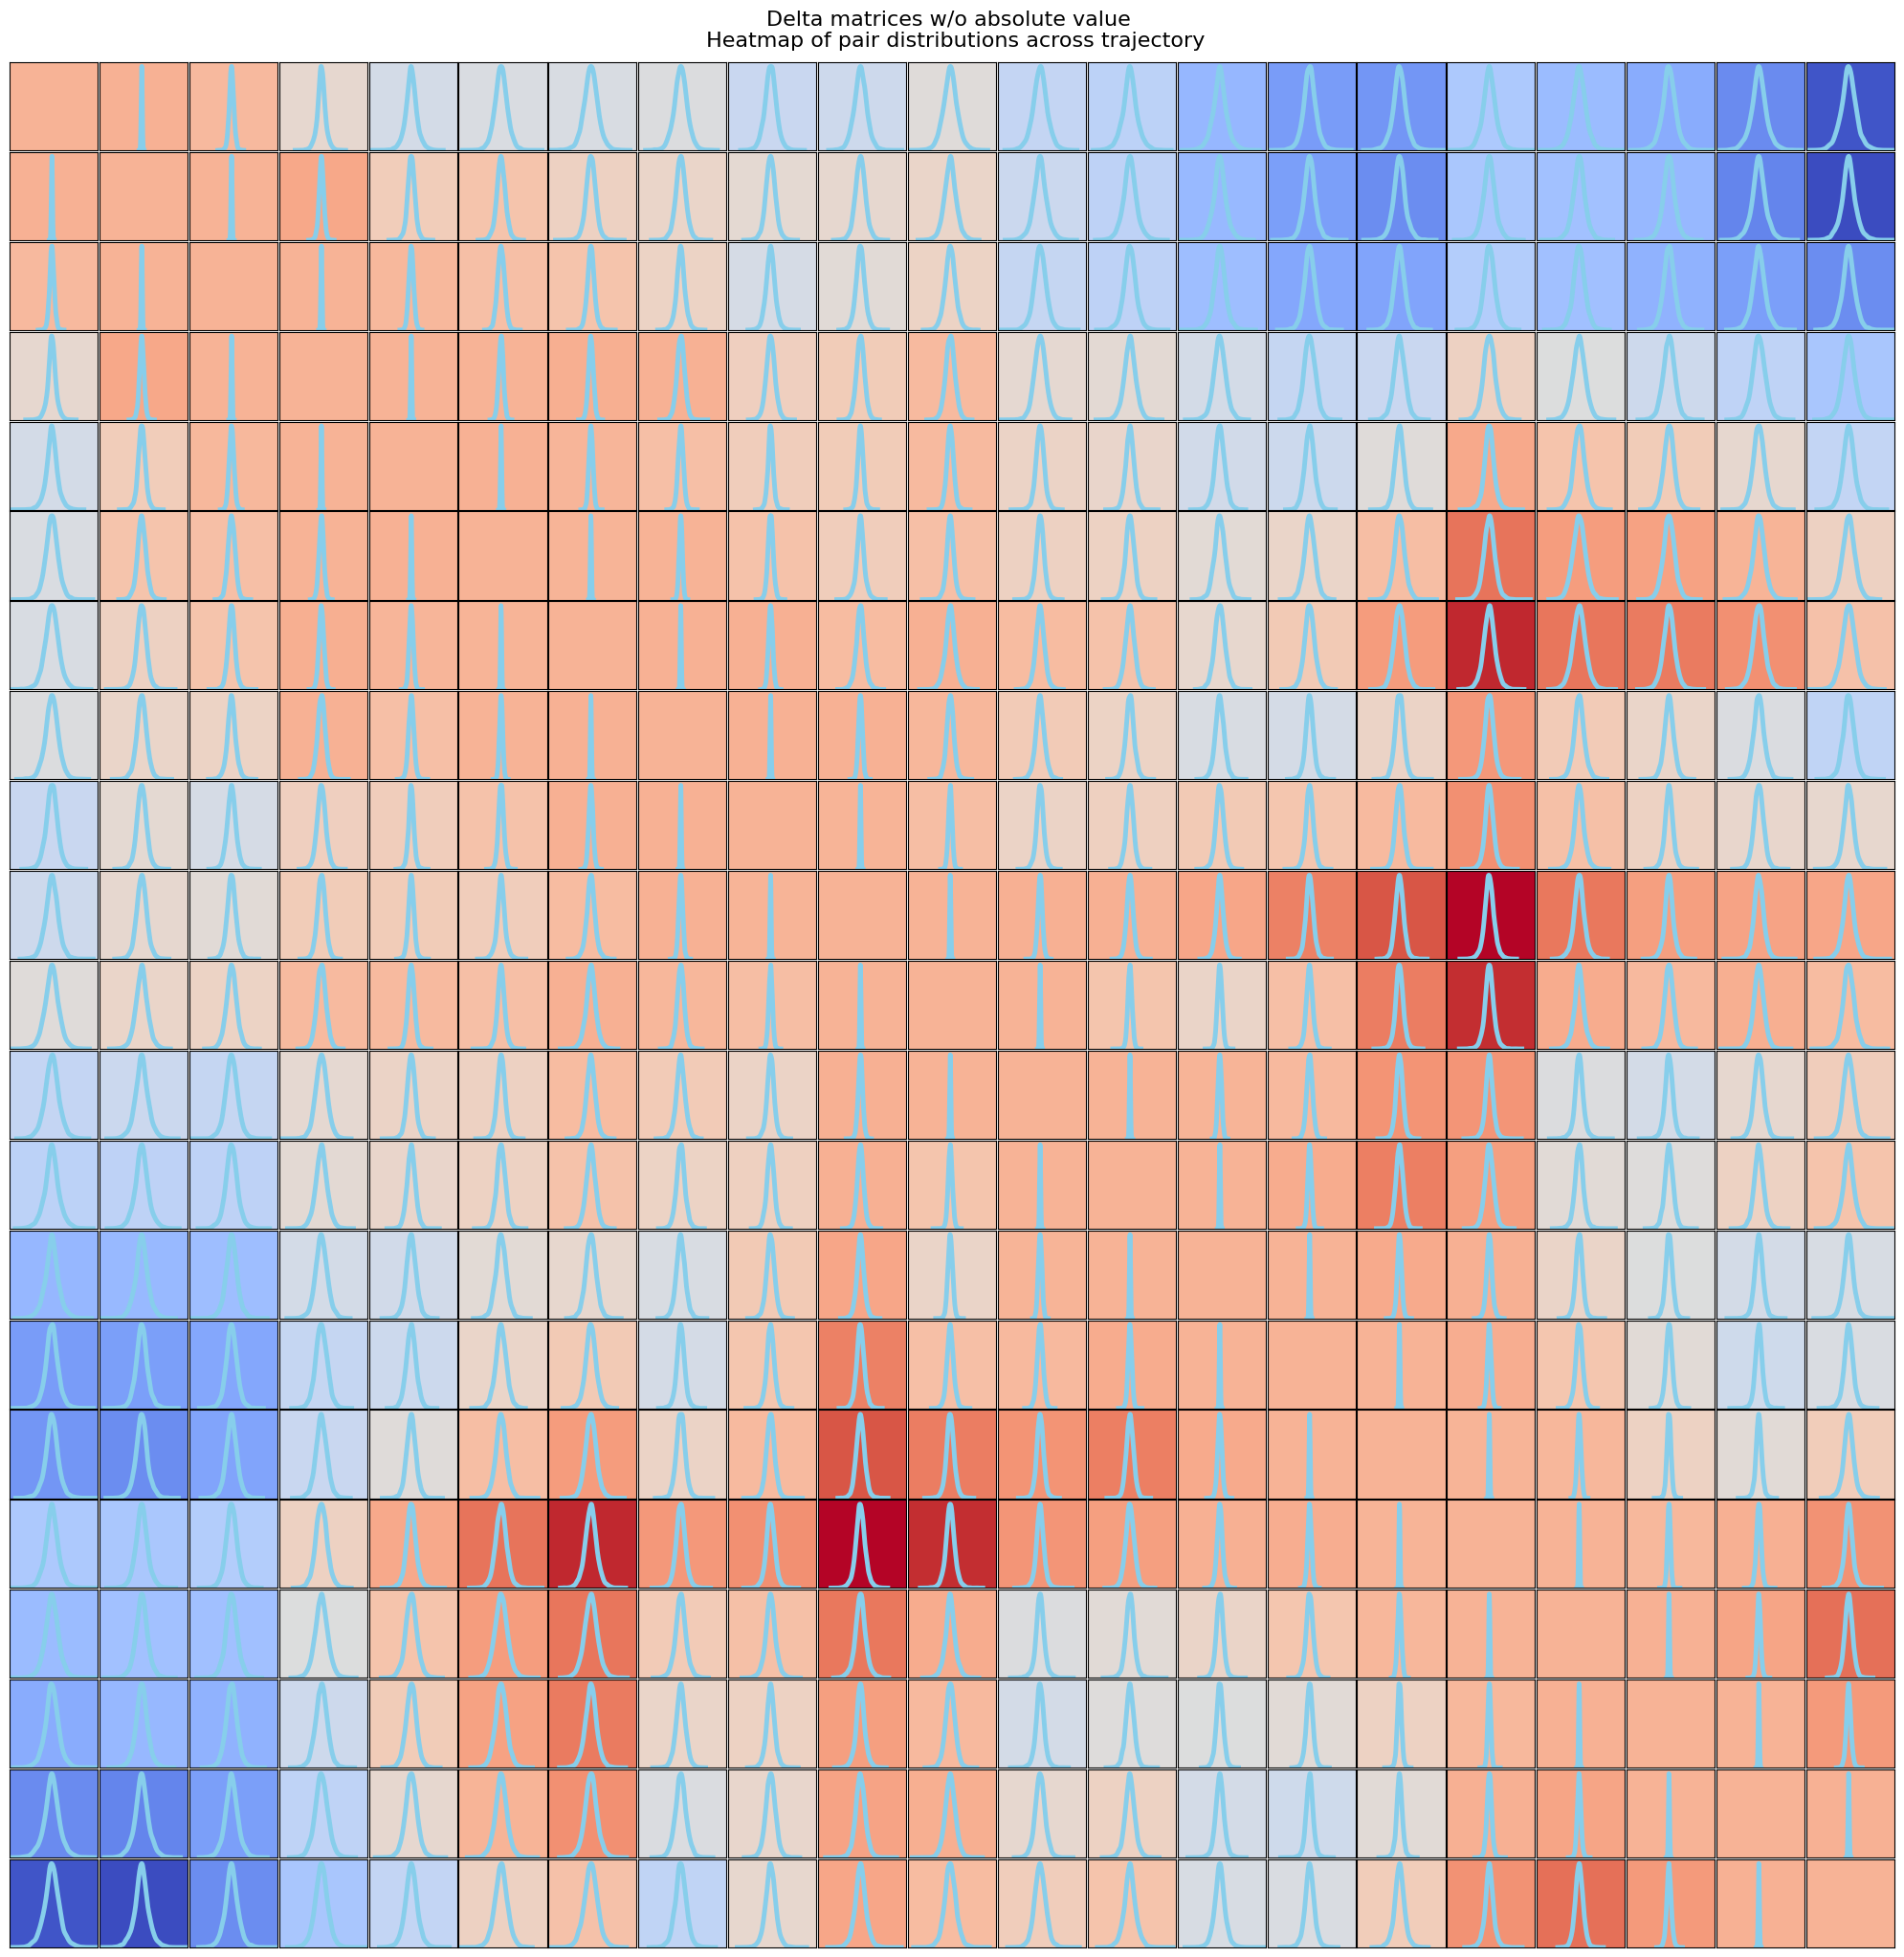

In [ ]:
dist_heatmaps_for_matrices(delta_matrices_wo_absolute,title="Delta matrices w/o absolute value \n Heatmap of pair distributions across trajectory")

# Further analyses

In [ ]:
Qs = []
for res in clustering_results:

    new_dist_Q_max_value, _ = get_Q_for_clustering_extended(dist_matrices, np.array(res), None, use_max=True, thinning_factor=None, only_adjacent=False, reference_frame=None, return_raw=False)
    Qs.append(new_dist_Q_max_value)

plt.bar(clustering_names, Qs, color='blue')
plt.xticks(rotation=45, ha='right') 

plt.tight_layout()

plt.title("Q_max from distance matrices, full")